In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, Concatenate, Add, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
import warnings
warnings.filterwarnings('ignore')

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

In [18]:
train_dir = "Data/train"
test_dir = "Data/test"
val_dir = "Data/valid"

In [19]:
path = "Data/train"
for files in os.listdir(path):
    print(os.path.join(path,files))

Data/train\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
Data/train\large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
Data/train\normal
Data/train\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


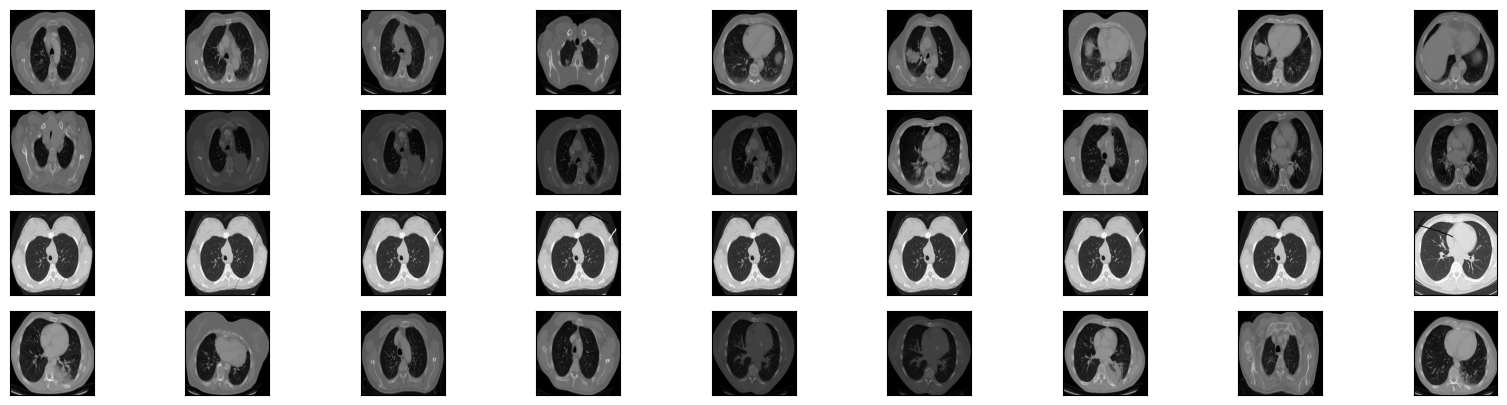

In [41]:
image_paths = [
    "Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib",
    "Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa",
    "Data/train/normal",
    "Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"
]

def load_images(image_paths, n = 36, resize_shape=(224, 224)):
    images = []
    for i in range(len(image_paths)):
        images_ = [cv2.resize(cv2.imread(image_paths[i]+'/'+path), resize_shape) for path in os.listdir(image_paths[i])[:int(n/4)]]
        images.append(images_)
    sample = np.asarray(images)
    return sample

sample = load_images(image_paths)
fig = plt.figure(figsize=(20,5))
l = 1
shapes = []
for i in range(sample.shape[0]):
    for m in range(sample.shape[1]):
        ax = fig.add_subplot(4,9,m+l,xticks = [], yticks = [])
        ax.imshow(np.squeeze(sample[i,m]))
        shapes.append(sample[i,m].shape)
    l +=9

plt.show()

In [43]:
np.array(shapes).mean(axis=0)

array([224., 224.,   3.])

In [47]:
image_shape = (224,224,3)
n_classes = 4
batch_size = 32

train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = batch_size,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                   batch_size = batch_size,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                   batch_size = batch_size,
                                                   target_size = (224,224),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [63]:
base_hidden_units = 8
weight_decay = 1e-3
model = Sequential([
    Conv2D(filters = 8, kernel_size=2, padding='same', activation='relu', input_shape = image_shape),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters = 16, kernel_size=2, padding='same', activation='relu', kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size=2),
    
    Dropout(0.4),
    Flatten(),
    Dense(300, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 8)       104       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 8)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 16)      528       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 56, 56, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 50176)            

In [64]:
checkpointer = ModelCheckpoint('chestmodel.hdf5', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
optimizer = optimizers.Adam(learning_rate=0.00001, decay= 1e-5)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
history = model.fit(train_generator,
                   steps_per_epoch=20,
                   epochs = 100,
                   verbose = 1,
                    validation_data = valid_generator,
                    callbacks = [checkpointer, early_stopping]
                   )

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.3501 - acc: 0.3524
Epoch 1: val_loss improved from inf to 1.46320, saving model to chestmodel.hdf5
20/20 [==============================] - 14s 177ms/step - loss: 1.3501 - acc: 0.3524 - val_loss: 1.4632 - val_acc: 0.3611
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 1.2654 - acc: 0.4258
Epoch 2: val_loss improved from 1.46320 to 1.35199, saving model to chestmodel.hdf5
20/20 [==============================] - 3s 146ms/step - loss: 1.2654 - acc: 0.4258 - val_loss: 1.3520 - val_acc: 0.3750
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 1.2133 - acc: 0.4519
Epoch 3: val_loss improved from 1.35199 to 1.32329, saving model to chestmodel.hdf5
20/20 [==============================] - 3s 146ms/step - loss: 1.2133 - acc: 0.4519 - val_loss: 1.3233 - val_acc: 0.3611
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 1.1712 - acc: 0.4763
Epoch 4: val_loss improved f

Epoch 30/100
20/20 [==============================] - ETA: 0s - loss: 0.6013 - acc: 0.8059
Epoch 30: val_loss improved from 0.80376 to 0.78838, saving model to chestmodel.hdf5
20/20 [==============================] - 3s 129ms/step - loss: 0.6013 - acc: 0.8059 - val_loss: 0.7884 - val_acc: 0.6806
Epoch 31/100
20/20 [==============================] - ETA: 0s - loss: 0.5786 - acc: 0.8206
Epoch 31: val_loss improved from 0.78838 to 0.78174, saving model to chestmodel.hdf5
20/20 [==============================] - 3s 126ms/step - loss: 0.5786 - acc: 0.8206 - val_loss: 0.7817 - val_acc: 0.6528
Epoch 32/100
20/20 [==============================] - ETA: 0s - loss: 0.5690 - acc: 0.8124
Epoch 32: val_loss did not improve from 0.78174
20/20 [==============================] - 2s 116ms/step - loss: 0.5690 - acc: 0.8124 - val_loss: 0.8419 - val_acc: 0.6111
Epoch 33/100
20/20 [==============================] - ETA: 0s - loss: 0.5488 - acc: 0.8287
Epoch 33: val_loss did not improve from 0.78174
20/20 [

20/20 [==============================] - ETA: 0s - loss: 0.3168 - acc: 0.9201
Epoch 60: val_loss did not improve from 0.64640
20/20 [==============================] - 2s 115ms/step - loss: 0.3168 - acc: 0.9201 - val_loss: 0.6703 - val_acc: 0.6944
Epoch 61/100
20/20 [==============================] - ETA: 0s - loss: 0.3181 - acc: 0.9184
Epoch 61: val_loss improved from 0.64640 to 0.63733, saving model to chestmodel.hdf5
20/20 [==============================] - 3s 130ms/step - loss: 0.3181 - acc: 0.9184 - val_loss: 0.6373 - val_acc: 0.7500
Epoch 62/100
20/20 [==============================] - ETA: 0s - loss: 0.3120 - acc: 0.9168
Epoch 62: val_loss did not improve from 0.63733
20/20 [==============================] - 3s 123ms/step - loss: 0.3120 - acc: 0.9168 - val_loss: 0.6850 - val_acc: 0.7083
Epoch 63/100
20/20 [==============================] - ETA: 0s - loss: 0.2888 - acc: 0.9282
Epoch 63: val_loss did not improve from 0.63733
20/20 [==============================] - 2s 121ms/step - 

Epoch 91/100
20/20 [==============================] - ETA: 0s - loss: 0.1975 - acc: 0.9543
Epoch 91: val_loss did not improve from 0.59724
20/20 [==============================] - 2s 124ms/step - loss: 0.1975 - acc: 0.9543 - val_loss: 0.6720 - val_acc: 0.7222
Epoch 92/100
20/20 [==============================] - ETA: 0s - loss: 0.1817 - acc: 0.9592
Epoch 92: val_loss did not improve from 0.59724
20/20 [==============================] - 2s 123ms/step - loss: 0.1817 - acc: 0.9592 - val_loss: 0.6372 - val_acc: 0.7361
Epoch 93/100
20/20 [==============================] - ETA: 0s - loss: 0.1682 - acc: 0.9657
Epoch 93: val_loss did not improve from 0.59724
20/20 [==============================] - 2s 122ms/step - loss: 0.1682 - acc: 0.9657 - val_loss: 0.6343 - val_acc: 0.7500
Epoch 94/100
20/20 [==============================] - ETA: 0s - loss: 0.1854 - acc: 0.9608
Epoch 94: val_loss did not improve from 0.59724
20/20 [==============================] - 3s 125ms/step - loss: 0.1854 - acc: 0.96

In [65]:
result = model.evaluate(test_generator)

10/10 [==============================] - 2s 175ms/step - loss: 1.3325 - acc: 0.5429


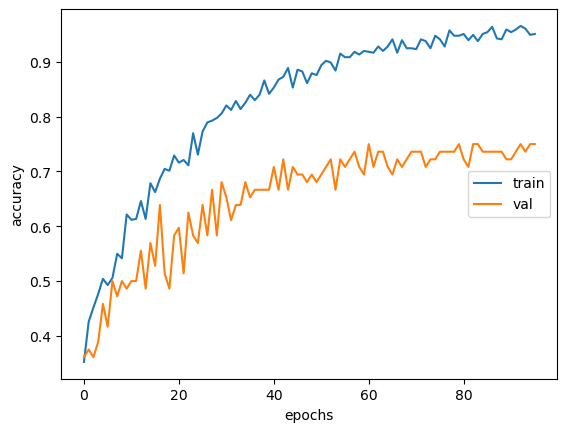

In [66]:
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()